
# The "Majority Illusion" in Scale-Free Networks — Reproduction of Fig. 2 (Fully Patched)

**Caption (paper):**  
*Plots show the magnitude of the illusion in scale-free networks as a function of degree–attribute correlation* $\rho_{kx}$ *and for different values of degree assortativity* $r_{kk}$. *Each network has 10,000 nodes and degree distribution of the form* $p(k)\sim k^{-\alpha}$. *The fraction of active nodes in all cases is 5%. The lines represent calculations using the statistical model of Eq (5).*

---

This notebook reproduces the three panels (for $\alpha\in\{2.1,2.4,3.1\}$) with practical patches:

- **X-axis uses measured $\rho_{kx}$**, not just the requested value.
- **Stronger rewiring** to reach a target $r_{kk}$ more reliably.
- **Heterogeneity control**: structural cutoff for $k_{\max}$ and an *optional* preset with $k_{\min}=1$ and larger cutoff to push $P_{>1/2}$ above 0.5.
- **Robust attribute assignment**: avoids numerical issues (e.g., divide-by-zero) using $\exp(\beta\log k)$ and safe handling when $k=0$ appears after simplification.
- **Domain toggle** for measuring the majority illusion: `"gcc"` (giant component) or `"all"` (whole graph with $k>0$).

> Everything below uses standard LaTeX delimiters `$...$`.


In [1]:

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional



## Configuration

- $N=10{,}000$, $p=0.05$ (5% prevalence).
- 12 points of $\rho_{kx}$ in $[0.00,0.55]$ by default.
- Target $r_{kk}$ per panel as in the paper.
- Structural cutoff $k_{\max}\approx \sqrt{N\langle k\rangle}$ with $\langle k\rangle\approx 8$.

You can turn on an **aggressive preset** (see next cell) to push $P_{>1/2}>0.5$.


In [2]:

@dataclass
class Config:
    # Core
    N: int = 10_000
    alphas: Tuple[float, ...] = (2.1, 2.4, 3.1)
    r_by_alpha: Dict[float, Tuple[float, ...]] = None
    rho_grid: Tuple[float, ...] = tuple(np.round(np.linspace(0.0, 0.55, 50), 2))
    p_global: float = 0.05  # 5%

    # Degree sequence (default, conservative)
    kmin: int = 1 #2
    kmax: Optional[int] = int(2*(10_000 * 8)**0.5)#None   # set below from structural cutoff

    # Rewiring targets/tolerances
    tol_r: float = 0.01
    max_rewire_steps_per_edge: float = 10 #8.0

    # Attribute assignment (rho_kx)
    tol_rho: float = 0.015
    max_bias_bisection: int = 30 # 24

    # Measurement
    sample_nodes: Optional[int] = None  # e.g., 4000 to accelerate
    trials_per_rho: int = 1
    domain_mode: str = "gcc"  # "gcc" or "all"

    # Reproducibility
    rng_seed: int = 123

CFG = Config()
CFG.r_by_alpha = {
    2.1: (-0.35, -0.25, -0.15, -0.05),
    2.4: (-0.20, -0.10,  0.00,  0.10,  0.20),
    3.1: (-0.15, -0.05,  0.00,  0.30),
}
# Structural cutoff suggestion: kmax ≈ sqrt(N * <k>) with <k> ~ 8
CFG.kmax = int((CFG.N * 8)**0.5)

CFG


Config(N=10000, alphas=(2.1, 2.4, 3.1), r_by_alpha={2.1: (-0.35, -0.25, -0.15, -0.05), 2.4: (-0.2, -0.1, 0.0, 0.1, 0.2), 3.1: (-0.15, -0.05, 0.0, 0.3)}, rho_grid=(np.float64(0.0), np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.06), np.float64(0.07), np.float64(0.08), np.float64(0.09), np.float64(0.1), np.float64(0.11), np.float64(0.12), np.float64(0.13), np.float64(0.15), np.float64(0.16), np.float64(0.17), np.float64(0.18), np.float64(0.19), np.float64(0.2), np.float64(0.21), np.float64(0.22), np.float64(0.24), np.float64(0.25), np.float64(0.26), np.float64(0.27), np.float64(0.28), np.float64(0.29), np.float64(0.3), np.float64(0.31), np.float64(0.33), np.float64(0.34), np.float64(0.35), np.float64(0.36), np.float64(0.37), np.float64(0.38), np.float64(0.39), np.float64(0.4), np.float64(0.42), np.float64(0.43), np.float64(0.44), np.float64(0.45), np.float64(0.46), np.float64(0.47), np.float64(0.48), np.float64(0.49), np.float64(0.51), np.float64(0.5


## Aggressive preset (optional)

Turn this **on** to push $P_{>1/2}$ above 0.5 without changing $p$:

- Set $k_{\min}=1$ and **double** the structural cutoff.
- Keep strong disassortativity reachable ($r_{kk}\approx-0.35$) by increasing `max_rewire_steps_per_edge`.
- Extend the $\rho_{kx}$ grid to $0.60$.

Set `USE_AGGRESSIVE_PRESET = True` to enable.


In [3]:

USE_AGGRESSIVE_PRESET = False  # <- set to True to push P_{>1/2} more easily

if USE_AGGRESSIVE_PRESET:
    CFG.kmin = 1
    CFG.kmax = int(2 * (CFG.N * 8)**0.5)
    CFG.max_rewire_steps_per_edge = max(CFG.max_rewire_steps_per_edge, 10.0)
    # extend rho grid to 0.60 with 13 points
    CFG.rho_grid = tuple(np.round(np.linspace(0.0, 0.60, 25), 2))
    # measure on full graph (k>0) to further increase P_{>1/2}
    CFG.domain_mode = "all"
    CFG





## Scale-free networks: degree sequence and simple graph

1. Sample a discrete degree sequence $k_i\sim k^{-\alpha}$ over $[k_{\min},k_{\max}]$.
2. Build a **simple** graph with `configuration_model` and remove self-loops / multi-edges.


In [4]:

def sample_powerlaw_degrees(N: int, alpha: float, kmin: int, kmax: int, rng):
    ks = np.arange(kmin, kmax + 1, dtype=int)
    pk = ks.astype(float) ** (-alpha)
    pk = pk / pk.sum()
    deg = rng.choice(ks, size=N, replace=True, p=pk)
    # force even sum
    if deg.sum() % 2 == 1:
        i = rng.integers(0, N)
        deg[i] = min(deg[i] + 1, kmax)
    return deg

def config_graph_from_seq(deg: np.ndarray, seed: int = 42) -> nx.Graph:
    Gm = nx.configuration_model(deg, seed=seed)
    G = nx.Graph(Gm)  # simple
    G.remove_edges_from(nx.selfloop_edges(G))
    return G



## Degree assortativity $r_{kk}$ via degree-preserving rewiring

Let $A=\sum_{(i,j)\in E} k_i k_j$. With fixed degrees, $B=\tfrac12\sum k_i^2$ and $C=\tfrac12\sum k_i^3$ are constants, so
$$
r_{kk}=\frac{A/M-(B/M)^2}{C/M-(B/M)^2}, \quad M=|E|.
$$
Edge swaps change $A$ by a known $\Delta A$. We accept swaps that move $A$ toward the target and keep the graph simple.


In [5]:

def _assort_constants(G: nx.Graph, deg: Dict[int, int] = None):
    if deg is None:
        deg = dict(G.degree())
    M = G.number_of_edges()
    dvals = np.array(list(deg.values()), dtype=float)
    B = 0.5 * np.sum(dvals ** 2)
    C = 0.5 * np.sum(dvals ** 3)
    A = 0
    for u, v in G.edges():
        A += deg[u] * deg[v]
    denom = (C / M) - (B / M) ** 2
    return A, B, C, M, denom, deg

def assort_from_A(A: float, B: float, C: float, M: float) -> float:
    return (A / M - (B / M) ** 2) / (C / M - (B / M) ** 2)

def rewire_to_rkk(G: nx.Graph, r_target: float, tol: float, max_rewire_steps_per_edge: float,
                  seed: int = 42, verbose: bool = False) -> float:
    rng = np.random.default_rng(seed)
    A, B, C, M, denom, deg = _assort_constants(G)
    if denom <= 0:
        return nx.degree_assortativity_coefficient(G)
    r = assort_from_A(A, B, C, M)
    edges: List[Tuple[int, int]] = list(G.edges())
    adj = {u: set(G.neighbors(u)) for u in G.nodes()}
    steps = int(max_rewire_steps_per_edge * M)
    direction = 1 if r_target > r else -1
    no_improve = 0

    for t in range(steps):
        i = rng.integers(len(edges)); j = rng.integers(len(edges))
        if i == j:
            continue
        a, b = edges[i]; c, d = edges[j]
        if len({a, b, c, d}) < 4:
            continue

        valid1 = (c not in adj[a]) and (d not in adj[b]) and (a != c) and (b != d)
        valid2 = (d not in adj[a]) and (c not in adj[b]) and (a != d) and (b != c)
        if not (valid1 or valid2):
            continue

        ka, kb, kc, kd = deg[a], deg[b], deg[c], deg[d]
        current = ka * kb + kc * kd
        delta1 = (ka * kc + kb * kd) - current  # (a,c),(b,d)
        delta2 = (ka * kd + kb * kc) - current  # (a,d),(b,c)

        cand = []
        if valid1: cand.append(("ac_bd", delta1))
        if valid2: cand.append(("ad_bc", delta2))
        if not cand:
            continue
        label, delta = max(cand, key=lambda x: x[1]) if direction > 0 else min(cand, key=lambda x: x[1])

        # early reject if it doesn't move in the right direction
        if (direction > 0 and delta <= 0) or (direction < 0 and delta >= 0):
            no_improve += 1
            if no_improve > 5000:
                r = assort_from_A(A, B, C, M)
                direction = 1 if r_target > r else -1
                no_improve = 0
            continue

        # apply swap
        G.remove_edge(a, b); adj[a].remove(b); adj[b].remove(a)
        G.remove_edge(c, d); adj[c].remove(d); adj[d].remove(c)
        if label == "ac_bd":
            G.add_edge(a, c); adj[a].add(c); adj[c].add(a)
            G.add_edge(b, d); adj[b].add(d); adj[d].add(b)
            edges[i] = (a, c); edges[j] = (b, d)
        else:
            G.add_edge(a, d); adj[a].add(d); adj[d].add(a)
            G.add_edge(b, c); adj[b].add(c); adj[c].add(b)
            edges[i] = (a, d); edges[j] = (b, c)

        A += delta
        r = assort_from_A(A, B, C, M)
        direction = 1 if r_target > r else -1

        if verbose and (t % (M // 2 + 1) == 0):
            print(f"[{t}/{steps}] r≈{r:.4f} (target {r_target:+.2f})")
        if abs(r - r_target) <= tol:
            break

    return r



## Attribute assignment: robust target $\rho_{kx}$ with fixed $p$

We build $x\in\{0,1\}^N$ with $E[x]=p$ and target $\rho_{kx}$.  
To avoid numerical issues:
- Replace $k=0$ by the smallest positive degree (or 1 if none).
- Use $w\propto \exp(\beta\log k)$ instead of $k^\beta$.
- Sanitize non-finite weights.


In [6]:

def _pearson_binary_k(k, x):
    k = np.asarray(k, dtype=float)
    x = np.asarray(x, dtype=float)
    k_c = k - k.mean()
    x_c = x - x.mean()
    denom = np.sqrt(np.sum(k_c**2) * np.sum(x_c**2))
    if denom == 0:
        return 0.0
    return float(np.dot(k_c, x_c) / denom)

def assign_attribute_with_rho_and_p(k: np.ndarray, rho_target: float, p: float,
                                    tol: float, max_iter: int, rng):
    N = len(k); m = int(round(p * N))
    m = max(1, min(N-1, m))  # avoid var(x)==0

    k = np.asarray(k, dtype=float)
    if np.any(k <= 0):
        pos = k[k > 0]
        kmin_pos = float(pos.min()) if pos.size > 0 else 1.0
        k_eff = k.copy()
        k_eff[k_eff <= 0] = kmin_pos
    else:
        k_eff = k

    logk = np.log(k_eff)
    lo, hi = -12.0, +12.0
    x_best, rho_best = None, -1.0

    for _ in range(max_iter):
        beta = 0.5 * (lo + hi)

        w = np.exp(beta * logk)
        w[~np.isfinite(w)] = 0.0
        s = w.sum()
        if not np.isfinite(s) or s <= 0.0:
            w = np.ones_like(w) / N
        else:
            w = w / s

        idx = rng.choice(N, size=m, replace=False, p=w)
        x = np.zeros(N, dtype=np.int8); x[idx] = 1

        rho = _pearson_binary_k(k, x)
        x_best, rho_best = x, rho

        if abs(rho - rho_target) <= tol:
            break
        if rho < rho_target: lo = beta
        else: hi = beta

    return x_best, rho_best



## Measuring $P_{>1/2}$ with a domain toggle

- `"gcc"`: only the giant component (default, closer to the paper).  
- `"all"`: the entire graph (nodes with $k>0$), which tends to **increase** $P_{>1/2}$.


In [7]:

def prob_majority(G: nx.Graph, x: np.ndarray, sample_nodes: Optional[int], domain: str, rng):
    if domain not in {"gcc", "all"}:
        raise ValueError("domain must be 'gcc' or 'all'")

    if domain == "gcc":
        GCC_nodes = max(nx.connected_components(G), key=len)
        H = G.subgraph(GCC_nodes).copy()
        nodes = np.array(list(H.nodes()), dtype=int)
        xH = x[nodes]
        A = nx.to_scipy_sparse_array(H, format="csr", dtype=np.int8)
        deg = np.asarray(A.sum(1)).ravel()
        ok = deg > 0
        if sample_nodes is not None and sample_nodes < ok.sum():
            idx = np.where(ok)[0]
            choose = rng.choice(idx, size=sample_nodes, replace=False)
            mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
            ok = mask
        counts = (A @ xH)
        return (counts[ok] > 0.5 * deg[ok]).mean()
    else:
        A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)
        deg = np.asarray(A.sum(1)).ravel()
        ok = deg > 0
        if sample_nodes is not None and sample_nodes < ok.sum():
            idx = np.where(ok)[0]
            choose = rng.choice(idx, size=sample_nodes, replace=False)
            mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
            ok = mask
        counts = (A @ x)
        return (counts[ok] > 0.5 * deg[ok]).mean()



## Panel runner (fixed $\alpha$)

For each target $r_{kk}$: build a network, tune $r_{kk}$, then sweep the requested $\rho_{kx}$ grid, **plotting vs the measured $\rho_{kx}$**.


In [8]:

def run_panel(alpha: float, r_targets: Tuple[float, ...], cfg: Config):
    rng = np.random.default_rng(cfg.rng_seed)
    results = {}
    r_measured = {}

    for r_target in r_targets:
        deg = sample_powerlaw_degrees(cfg.N, alpha, cfg.kmin, cfg.kmax, rng)
        G = config_graph_from_seq(deg, seed=cfg.rng_seed)
        r_real = rewire_to_rkk(G, r_target, cfg.tol_r, cfg.max_rewire_steps_per_edge, seed=cfg.rng_seed, verbose=False)
        r_measured[r_target] = r_real
        k = np.array([d for _, d in sorted(G.degree(), key=lambda x: x[0])], dtype=int)

        rho_meas, pmaj_vals = [], []
        for rho_target in cfg.rho_grid:
            rvals, pvals = [], []
            for _ in range(cfg.trials_per_rho):
                x, rho_real = assign_attribute_with_rho_and_p(k, rho_target, cfg.p_global,
                                                              cfg.tol_rho, cfg.max_bias_bisection, rng)
                p = prob_majority(G, x, cfg.sample_nodes, cfg.domain_mode, rng)
                rvals.append(rho_real); pvals.append(p)
            rho_meas.append(float(np.mean(rvals)))
            pmaj_vals.append(float(np.mean(pvals)))

        order = np.argsort(rho_meas)
        results[r_target] = (np.array(rho_meas)[order], np.array(pmaj_vals)[order])

    return results, r_measured



## Final figure: three panels in one row


In [9]:

def run_all_panels(cfg: Config):
    results_by_alpha, r_meas_by_alpha = {}, {}
    for a in cfg.alphas:
        res, r_meas = run_panel(a, cfg.r_by_alpha[a], cfg)
        results_by_alpha[a] = res
        r_meas_by_alpha[a] = r_meas
    return results_by_alpha, r_meas_by_alpha

def plot_three_panels(results_by_alpha, r_meas_by_alpha, cfg: Config):
    fig, axes = plt.subplots(1, 3, figsize=(13.5, 4), dpi=120, sharex=True, sharey=True)
    marker_sets = {2.1:["o","^","s","x"], 2.4:["o","^","s","D","x"], 3.1:["o","^","s","x"]}
    titles = {2.1:r"(a) $\alpha=2.1$", 2.4:r"(b) $\alpha=2.4$", 3.1:r"(c) $\alpha=3.1$"}

    for ax, a in zip(axes, cfg.alphas):
        markers = marker_sets[a]
        for i, r_target in enumerate(cfg.r_by_alpha[a]):
            rhos, vals = results_by_alpha[a][r_target]
            lab = rf"$r_{{kk}}={r_meas_by_alpha[a][r_target]:+.2f}$"
            ax.plot(rhos, vals, marker=markers[i%len(markers)], linewidth=1.8, markersize=5.5, label=lab)

        ax.set_title(titles[a])
        ax.grid(True, alpha=.25, linestyle="--")
        ax.set_xlim(min(cfg.rho_grid)-0.02, max(cfg.rho_grid)+0.02)
        ax.set_ylim(0, 1.0)
        ax.set_xlabel(r"k–x correlation, $\rho_{kx}$")
        if a == cfg.alphas[0]:
            ax.set_ylabel(r"Probability of majority, $P_{>1/2}$")
        ax.legend(frameon=True, loc="upper left", fontsize=9)

    plt.tight_layout()
    plt.show()



## Run

> With $N=10{,}000$ this may take time. To accelerate: set `CFG.sample_nodes = 4000` and/or `CFG.max_rewire_steps_per_edge = 4.0`.


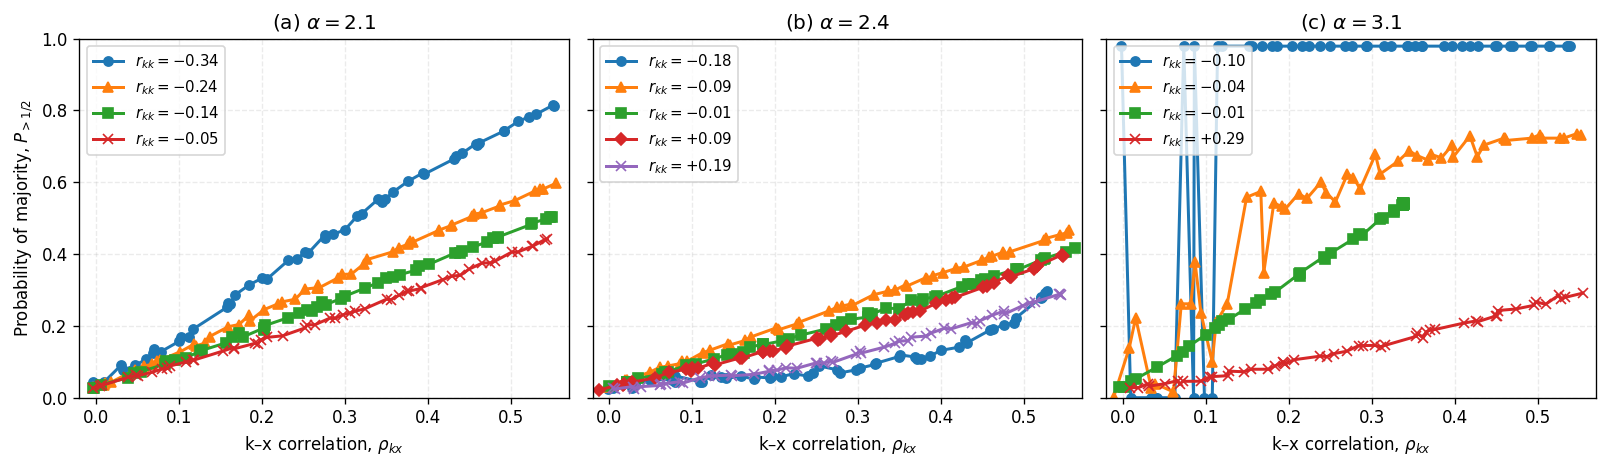

In [10]:

# Example acceleration toggles (uncomment as needed)
# CFG.sample_nodes = 4000
# CFG.max_rewire_steps_per_edge = 4.0

results_by_alpha, r_meas_by_alpha = run_all_panels(CFG)
plot_three_panels(results_by_alpha, r_meas_by_alpha, CFG)
